In [9]:
import math
import pandas as pd
import numpy as np
import random
from scipy.interpolate import UnivariateSpline
from scipy.stats import rankdata
from scipy.special import logit as logit
from matplotlib import pyplot as plt

from cdlib import algorithms, viz
import community as community_louvain
import networkx as nx
from networkx.algorithms import community
from networkx.algorithms.community import k_clique_communities,label_propagation_communities, asyn_lpa_communities,greedy_modularity_communities
from networkx.algorithms.centrality import *
from networkx.algorithms.cluster import *
# import igraph as ig

from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler 
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
 
from xgboost import XGBClassifier
import seaborn as sns

clinical_231_file = 'C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\clinical_231_data.csv'
mRNA_231_file = 'C:\\Users\\bird\\Desktop\\cancer_project_github\\cancer_data\\data_mRNA_231_sort_with_sensitive.csv'
id_symbol_lookup_file = 'C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\Hugo_Symbol_to_id.csv'
# filterd_data = 'C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\filtered_133_genes_data.csv'
filterd_data = 'C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\union_genes_4803.csv'

# Gene network generation (weighted-> unweighted)

In [12]:
# df = pd.read_csv(filterd_data).drop(columns = ['ID']).T
# correlations = np.corrcoef(df, df)[:4803, :4803]
# for i in range(correlations.shape[0]):
#     correlations[i][i]=0
# for i in range(correlations.shape[0]):
#     for j in range(correlations.shape[0]):
#         if correlations[i][j] < 0.1 and correlations[i][j]>-0.1:
#             correlations[i][j]  = 0
#         else:
#             correlations[i][j]  = 1
# correlations

# G = nx.Graph()
# G.add_nodes_from(np.arange(4803))
# G.nodes()
# edge_list = []
# for i in range(correlations.shape[0]):
#      for j in range(i+1, correlations.shape[0]):
#             if correlations[i][j] == 1:
#                 edge_list.append((i,j))

# len(edge_list)
# G.add_edges_from(edge_list)
# G.remove_nodes_from(list(nx.isolates(G)))
# G.number_of_nodes()

def const_net(correlation, threshold):
    correlations = np.copy(correlation)
    for i in range(correlations.shape[0]):
        correlations[i][i]=0
    for i in range(correlations.shape[0]):
        for j in range(correlations.shape[0]):
            if correlations[i][j] < threshold and correlations[i][j]>-threshold:
                correlations[i][j]  = 0
            else:
                correlations[i][j]  = 1

    G = nx.Graph()
    G.add_nodes_from(np.arange(correlations.shape[0]))
    edge_list = []
    for i in range(correlations.shape[0]):
         for j in range(i+1, correlations.shape[0]):
                if correlations[i][j] == 1:
                    edge_list.append((i,j))

    print(len(edge_list))
    G.add_edges_from(edge_list)
    G.remove_nodes_from(list(nx.isolates(G)))
    return G
  

In [94]:
a = np.arange(8)
a = np.delete(a, np.where(a == 2))
a = np.delete(a, np.where(a == 2))
a

array([0, 1, 3, 4, 5, 6, 7])

In [13]:
df = pd.read_csv(filterd_data).drop(columns = ['ID'])
correlations = np.corrcoef(df, df)[:4803, :4803]
print(correlations.shape)
for i in range(correlations.shape[0]):
    correlations[i][i]=0
for i in range(correlations.shape[0]):
    for j in range(correlations.shape[0]):
        if correlations[i][j] < 0.5 and correlations[i][j]>-0.5:
            correlations[i][j]  = 0
        else:
            correlations[i][j]  = 1
#             nodes =  np.delete(nodes, np.where(nodes == i))
#             nodes =  np.delete(nodes, np.where(nodes == j))
print(correlations)

G = nx.Graph()
# nodes = np.setdiff1d( np.arange(4803),nodes)
# G.add_nodes_from(nodes)
G.add_nodes_from(np.arange(4803))

edge_list = []

for i in range(correlations.shape[0]):
     for j in range(i+1, correlations.shape[0]):
            if correlations[i][j] == 1:
                edge_list.append((i,j))

print(len(edge_list))
G.add_edges_from(edge_list)
G.remove_nodes_from(list(nx.isolates(G)))

print(G.number_of_nodes())
com = algorithms.demon(G, min_com_size=50, epsilon=0.25) # works

m = com.link_modularity()
print(m)

In [17]:
df = pd.read_csv(filterd_data).drop(columns = ['ID'])
correlations = np.corrcoef(df, df)[:4803, :4803]

coms = []
modularities = []
for thre in np.arange(0.5, 0.6, 0.01):
    print(thre)
    G = const_net(correlations, thre)
    print(G.number_of_nodes())
    com = algorithms.demon(G, min_com_size=50, epsilon=0.25) # works
    coms.append(com)
    m = com.link_modularity()
    print(m)
    modularities.append(m)
print(modularities)

# com = algorithms.lais2(G)# take loooong time
# com = algorithms.conga(G, number_communities=7) # take loooong time
#     com = algorithms.demon(G, min_com_size=10, epsilon=0.25) # works
#     com = algorithms.node_perception(G, threshold=0.25, overlap_threshold=0.25) #works longer time
# com = algorithms.lfm(G, alpha=1) # loong time

# coms = algorithms.egonet_splitter(G)
# coms = algorithms.angel(G, min_com_size=3, threshold=0.25) # min_community_size – minimum community size, default 3.
# coms = algorithms.big_clam(G) 
# coms = algorithms.danmf(G) # complex model
# com = algorithms.kclique(G, k=3) #k – Size of smallest clique
# coms = algorithms.slpa(G)
# coms = algorithms.percomvc(G)
# com = algorithms.overlapping_seed_set_expansion(G) # complex model
# coms = algorithms.node_perception(G, threshold=0.25, overlap_threshold=0.25)
# coms = algorithms.nnsed(G)
# coms = algorithms.nmnf(G) #complex model
# coms = algorithms.lemon(G, seeds, min_com_size=20, max_com_size=50) #complex model
# com = algorithms.congo(G, number_communities=3, height=2) # number_communities – the number of communities desired.height – The lengh of the longest shortest paths that CONGO considers, default 2

0.5
188522
4071
FitnessResult(min=None, max=None, score=0.22012300792384745, std=None)
0.51
169098
3979
FitnessResult(min=None, max=None, score=0.2417357284473682, std=None)
0.52
151640
3857
FitnessResult(min=None, max=None, score=0.23993355514312, std=None)
0.53
135967
3748
FitnessResult(min=None, max=None, score=0.2605213196686659, std=None)
0.54
122126
3619
FitnessResult(min=None, max=None, score=0.2722639799519779, std=None)
0.55
109703
3491
FitnessResult(min=None, max=None, score=0.22737862230893824, std=None)
0.56
98622
3379
FitnessResult(min=None, max=None, score=0.20021895254010327, std=None)
0.5700000000000001
88759
3269
FitnessResult(min=None, max=None, score=0.1638006893246137, std=None)
0.5800000000000001
79930
3133
FitnessResult(min=None, max=None, score=0.1612551610240643, std=None)
0.5900000000000001
71876
3006
FitnessResult(min=None, max=None, score=0.15252955357608233, std=None)
[FitnessResult(min=None, max=None, score=0.22012300792384745, std=None), FitnessResult(min=

In [57]:
com = coms[4]
com.to_node_community_map()
# 11 clusters: 0-10

defaultdict(list,
            {2: [0, 1, 2, 3, 4, 5, 6],
             4: [0, 1, 2, 3, 4, 5, 6, 7],
             12: [0, 3, 4, 5],
             17: [0, 1, 2, 3, 4, 5, 6, 7, 8],
             24: [0, 3, 4, 5],
             25: [0, 1, 2, 3],
             26: [0, 1, 2, 3, 4],
             27: [0, 1, 2, 3, 4],
             31: [0, 1, 2, 3, 4, 5, 6, 7, 8],
             32: [0, 1, 2, 3, 4],
             33: [0, 1, 2, 3, 4],
             35: [0, 1, 2, 3, 4],
             38: [0, 1, 2, 3],
             40: [0, 1, 2, 3, 4, 5, 6, 8],
             41: [0, 1, 2, 3, 4],
             42: [0, 1, 2, 3, 4, 5, 6],
             46: [0, 1, 2, 3, 4, 5, 6, 8],
             47: [0, 1, 2, 3, 4, 5, 6, 8],
             49: [0, 1, 2, 3],
             50: [0, 1, 2, 3, 4],
             51: [0, 1, 2, 3, 4],
             53: [0, 1, 2, 3, 4, 5, 6],
             54: [0, 1, 2, 3, 4, 5, 6],
             55: [0, 1, 3, 4, 5],
             58: [0, 1, 2, 3, 4],
             60: [0, 1, 2, 3, 4, 5, 6],
             62: [0, 1, 2

In [59]:

# print(conmmunities[10]) 
# https://stackoverflow.com/questions/43541376/how-to-draw-communities-with-networkx


[1032, 1814, 2239, 3292, 3454, 3543, 3783, 4069, 4077, 4111, 4189, 4197, 4280, 4365, 4484, 4713, 4784, 3464, 3792, 4579, 4701, 2859, 4250, 4373, 4586, 4302, 4762, 3794, 4195, 4635, 803, 1590, 1752, 2084, 2631, 2698, 2842, 2940, 3035, 3131, 3171, 3350, 3359, 3363, 3389, 3415, 3426, 3562, 3574, 3578, 3635, 3711, 3717, 3734, 3739, 3749, 3758, 3807, 3839, 3904, 3911, 3912, 3963, 3973, 3997, 4005, 4009, 4010, 4026, 4049, 4050, 4062, 4063, 4087, 4088, 4119, 4122, 4127, 4130, 4177, 4191, 4252, 4276, 4288, 4321, 4324, 4325, 4359, 4380, 4389, 4395, 4404, 4405, 4411, 4413, 4414, 4450, 4466, 4471, 4473, 4482, 4486, 4504, 4509, 4512, 4539, 4541, 4545, 4550, 4555, 4565, 4577, 4587, 4599, 4602, 4619, 4625, 4627, 4632, 4637, 4645, 4649, 4663, 4665, 4676, 4681, 4683, 4699, 4708, 4711, 4732, 4733, 4734, 4749, 4755, 4757, 4760, 4788]


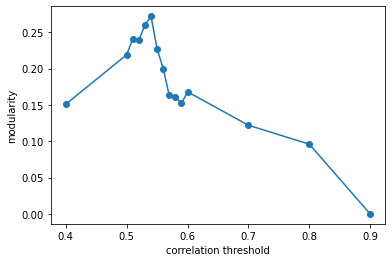

In [22]:
# 0.3 :1640970 4803
# 0.4 :573764 4745 FitnessResult(min=None, max=None, score=0.15127569396624832, std=None)
# 0.5 :188522 4071 FitnessResult(min=None, max=None, score=0.21970101429567895, std=None)
# 0.51 169098 3979 FitnessResult(min=None, max=None, score=0.2417357284473682, std=None)
# 0.52 151640 3857 FitnessResult(min=None, max=None, score=0.23993355514312, std=None)
# 0.53 135967 3748 FitnessResult(min=None, max=None, score=0.2605213196686659, std=None)
# 0.54 122126 3619 FitnessResult(min=None, max=None, score=0.2722639799519779, std=None) 2886 nodes
# 0.55 109703 3491 FitnessResult(min=None, max=None, score=0.22737862230893824, std=None)
# 0.56 98622 3379 FitnessResult(min=None, max=None, score=0.20021895254010327, std=None)
# 0.57 88759 3269 FitnessResult(min=None, max=None, score=0.1638006893246137, std=None)
# 0.58 79930 3133 FitnessResult(min=None, max=None, score=0.1612551610240643, std=None)
# 0.59 71876 3006 FitnessResult(min=None, max=None, score=0.15252955357608233, std=None)
# 0.6 :64496 2886FitnessResult(min=None, max=None, score=0.16896384714919208, std=None)
# 0.7 :21395 1553 FitnessResult(min=None, max=None, score=0.12196361112524495, std=None)
# 0.8 :4460 664 FitnessResult(min=None, max=None, score=0.0964465467565242, std=None)
# 0.9 :172 116 FitnessResult(min=None, max=None, score=0.0, std=None)

thresholds_list = [0.4,0.5,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59,0.6,0.7,0.8,0.9]
modularities = [0.151,0.219,0.241,0.239, 0.260, 0.272, 0.227, 0.200,0.163,0.1612551,0.152,0.168,0.122,0.096,0]

plt.figure()
plt.xlabel('correlation threshold')
plt.ylabel('modularity')
plt.plot(thresholds_list, modularities)
plt.scatter(thresholds_list, modularities)
plt.show()

# With threshold 0.54

In [64]:
df = pd.read_csv(filterd_data).drop(columns = ['ID'])
correlations = np.corrcoef(df, df)[:4803, :4803]

thre = 0.54
G = const_net(correlations, thre)
print(G.number_of_nodes())
com = algorithms.demon(G, min_com_size=50, epsilon=0.25) # works
m = com.link_modularity()
print(m)


122126
3619
FitnessResult(min=None, max=None, score=0.2522869327229162, std=None)
[0.151, 0.219, 0.241, 0.239, 0.26, 0.272, 0.227, 0.2, 0.163, 0.1612551, 0.152, 0.168, 0.122, 0.096, 0]


In [ ]:
# clusters = com.to_node_community_map()
# conmmunities = []
# for i in range(11):
#     conmmunities.append([])


# for i in clusters.keys():
#     c = clusters[i]
#     for j in c:
#         conmmunities[j].append(i)

viz.plot_network_clusters(G, com,figsize=(15,15) ,node_size=50, plot_overlaps=True )

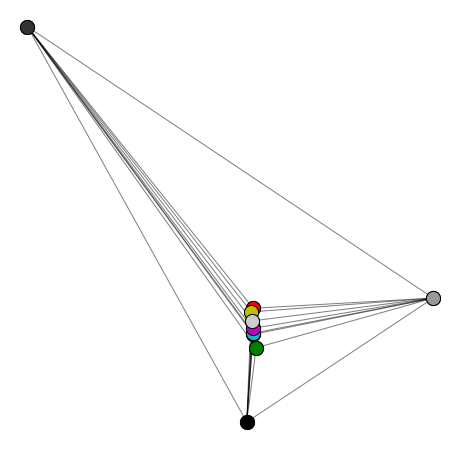

In [66]:
viz.plot_community_graph(G, com)

# previous work


patient network

In [2]:
df = pd.read_csv(filterd_data).drop(columns = ['Hugo_ID']).T
correlations = np.corrcoef(df, df)[:231, :231]
for i in range(correlations.shape[0]):
    correlations[i][i]=0
for i in range(correlations.shape[0]):
    for j in range(correlations.shape[0]):
        if correlations[i][j] < 0:
            correlations[i][j]  = -correlations[i][j] 
            
ex_df = pd.DataFrame(correlations)

G = nx.Graph()
G.add_nodes_from(np.arange(231))
# G.nodes()
for i in range(correlations.shape[0]-1):
    for j in range(i+1,correlations.shape[0]):
        G.add_edge(i, j, weight=correlations[i][j])
#         print(correlations[i][j])



df = pd.DataFrame()
de = G.degree(weight='weight')
cc = nx.clustering(G,weight='weight')

df['weighted_degree'] = np.array(de).T[1][:]
df['weighted_clustering_coef'] = cc.values()


thres_media = np.median(correlations)
G = nx.Graph()
G.add_nodes_from(np.arange(231))
# G.nodes()
for i in range(correlations.shape[0]-1):
    for j in range(i+1,correlations.shape[0]):
        if correlations[i,j] > thres_media:
            G.add_edge(i, j)
de = G.degree()
cc = nx.clustering(G)

df['degree'] = np.array(de).T[1][:]
df['clustering_coef'] = cc.values()      
df.round(3)
df
# df.to_csv("C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\patient_net_features.csv")

In [3]:
df = pd.read_csv(filterd_data)
df = df.drop(columns = ['Hugo_ID'])
cancer_types =  [0]*117+[1]*74+[2]*40
print(len(cancer_types))
# sns.countplot(x = 'Hugo_ID', data=df)


# df['cancer'] = cancer_types

correlations = np.corrcoef(df, df)[:133, :133]

for i in range(correlations.shape[0]):
    correlations[i][i]=0
for i in range(correlations.shape[0]):
    for j in range(correlations.shape[0]):
        if correlations[i][j] < 0:
            correlations[i][j]  = -correlations[i][j] 
#         if correlations[i][j] < 0.2:
#             correlations[i][j]  = 0
#         correlations[i][j] = math.floor(correlations[i][j]*100)
correlations # weighted network matrix
# ex_df = pd.DataFrame(correlations)
# ex_df.to_csv("C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\network_matrix.csv")
# np_pos = np.zeros((133,133))
# np_neg = np.zeros((133,133))
# for i in range(correlations.shape[0]):
#     for j in range(correlations.shape[0]):
#         if correlations[i][j] > 0:
#             np_pos[i][j] = correlations[i][j] 
#         if correlations[i][j] < 0:
#             np_neg[i][j] = -correlations[i][j] 
# ex_df = pd.DataFrame(np_pos)
# ex_df.to_csv("C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\network_matrix_pos.csv")
# ex_df = pd.DataFrame(np_neg)
# ex_df.to_csv("C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\network_matrix_abs.csv")

231


array([[0.        , 0.74065188, 0.50100018, ..., 0.01460397, 0.23895306,
        0.01588378],
       [0.74065188, 0.        , 0.17325192, ..., 0.0707046 , 0.17785555,
        0.04636617],
       [0.50100018, 0.17325192, 0.        , ..., 0.00584516, 0.44585732,
        0.00200516],
       ...,
       [0.01460397, 0.0707046 , 0.00584516, ..., 0.        , 0.23463521,
        0.29402463],
       [0.23895306, 0.17785555, 0.44585732, ..., 0.23463521, 0.        ,
        0.45071698],
       [0.01588378, 0.04636617, 0.00200516, ..., 0.29402463, 0.45071698,
        0.        ]])

In [5]:

G = nx.Graph()
G.add_nodes_from(np.arange(133))
G.nodes()
for i in range(correlations.shape[0]-1):
    for j in range(i+1,correlations.shape[0]):
        G.add_edge(i, j, weight=correlations[i][j])
#         print(correlations[i][j])
        

G.number_of_nodes()

133

In [36]:
# ccc = asyn_lpa_communities(G,weight='weight')
# next(ccc)
# greedy_modularity_communities(G,weight='weight' )


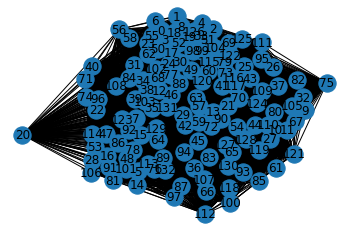

In [6]:

plt.subplot()
nx.draw(G, with_labels=True)
plt.show()

In [20]:

wc = algorithms.wCommunity(G, min_bel_degree=0.99999, threshold_bel_degree=0.99999, weightName='weight')

# wc
wc.to_json()
wc = algorithms.louvain(G,weight='weight',resolution=0.5)
print(wc.to_node_community_map())
print("--------------")
ccc = asyn_lpa_communities(G,weight='weight')
print(len(next(ccc)))
print("--------------")
gmc = greedy_modularity_communities(G,weight='weight' )
print(gmc)
print("--------------")
bp = community_louvain.best_partition(G,weight='weight', resolution=0.5)
print(bp)

'{"communities": [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132]], "algorithm": "wCommunity", "params": {"min_bel_degree": 0.99999, "threshold_bel_degree": 0.99999, "weightName": "weight"}, "overlap": true, "coverage": 1.0}'

In [4]:
df = pd.DataFrame()
de = G.degree(weight='weight')
b = betweenness_centrality(G,weight = 'weight')
# print(b)
e = eigenvector_centrality(G,weight = 'weight')
# print(e)
i = information_centrality(G,weight = 'weight')
# print(i)
cc = nx.clustering(G,weight='weight')
df['degree'] = np.array(de).T[1][:]
df['clustering_coef'] = cc.values()
df['betweenness'] = b.values()
df['eigenvector'] = e.values()
df['closeness'] = i.values()
df.round(3)

,degree,clustering_coef,betweenness,eigenvector,closeness
0,37.068,0.185,0.107,0.128,0.104
1,25.771,0.153,0.000,0.086,0.090
2,36.064,0.182,0.006,0.128,0.103
3,35.926,0.183,0.000,0.125,0.103
4,35.315,0.181,0.000,0.125,0.102
...,...,...,...,...,...
128,25.487,0.138,0.023,0.052,0.089
129,31.071,0.172,0.012,0.073,0.097
130,17.225,0.112,0.015,0.034,0.073
131,36.866,0.211,0.000,0.102,0.104


In [5]:
# df.to_csv("C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\network_features_133.csv")
df

,degree,clustering_coef,betweenness,eigenvector,closeness
0,37.068241,0.185392,0.107449,0.128421,0.104133
1,25.770810,0.152595,0.000000,0.086084,0.089725
2,36.063570,0.181958,0.006130,0.128194,0.102997
3,35.926064,0.182528,0.000000,0.125222,0.102907
4,35.315217,0.181160,0.000000,0.124995,0.102200
...,...,...,...,...,...
128,25.487240,0.138486,0.023479,0.051816,0.089273
129,31.070944,0.171599,0.012260,0.072824,0.097389
130,17.225014,0.111606,0.014573,0.033870,0.073226
131,36.865576,0.210740,0.000000,0.101698,0.104416


# Decision Tree


In [ ]:

filterd_data = 'C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\filtered_133_genes_data.csv'
network_features = 'C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\patient_net_features.csv'

features_df = pd.read_csv(network_features)

genes_df = pd.read_csv(filterd_data)
df = genes_df.drop(columns = ['Hugo_ID'])
cancer_types =  [0]*117+[1]*74+[2]*40
print(len(cancer_types))
# sns.countplot(x = 'Hugo_ID', data=df)
df = df.T
# df['degree'] = list(features_df['degree'])
# df['clustering_coef'] = list(features_df['clustering_coef'])
# df['betweenness'] = list(features_df['betweenness'])
# df['eigenvector'] = list(features_df['eigenvector'])
# df['closeness'] = list(features_df['closeness'])
df['cancer'] = cancer_types
# print(df)

sns.countplot(x = 'cancer', data=df)

class2idx = {
    0:0,
    1:1,
    2:2
}

idx2class = {v: k for k, v in class2idx.items()}

df['cancer'].replace(class2idx, inplace=True)

X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

In [ ]:
print(X)

In [65]:
#Training testing data splite

# class2idx = {
#     0:0,
#     1:1,
#     2:2
# }
# idx2class = {v: k for k, v in class2idx.items()}
# df['cancer'].replace(class2idx, inplace=True)
# X = df.iloc[:, 0:-1]
# y = df.iloc[:, -1]
# print(X,y)
# # Split train into train-val
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=21)
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)
# X_train, y_train = np.array(X_train), np.array(y_train)
# X_val, y_val = np.array(X_val), np.array(y_val)
# print("Train set datapoints: "+str(len(X_train)))
# print("Validation set datapoints: "+str(len(X_val)))
# def get_class_distribution(obj):
#     count_dict = {
#         "LN": 0,
#         "Bone": 0,
#         "Liver": 0
#     } 
#     for i in obj:
#         if i == 0: 
#             count_dict['LN'] += 1
#         elif i == 1: 
#             count_dict['Bone'] += 1
#         elif i == 2: 
#             count_dict['Liver'] += 1          
#         else:
#             print("Check classes.")          
#     return count_dict
# ax = sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(),\
#             x = "variable", y="value")
# ax.set(xlabel="Cancer type", ylabel = "Cases number", title="Class Distribution in Train Set")
# plt.show(ax)
# ax2 = sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), \
#             x = "variable", y="value")
# ax2.set(xlabel="Cancer type", ylabel = "Cases number",title="Class Distribution in Validation Set")
# plt.show(ax2)

In [88]:


# print(X,y)

model = XGBClassifier()
# kfold = KFold(n_splits=10,shuffle=True)

results = cross_val_score(model, X, y, cv=10)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
y_pred = cross_val_predict(model, X, y, cv=10)
conf_mat = confusion_matrix(y, y_pred)
print(conf_mat)


Accuracy: 93.50% (4.46%)
[[115   2   0]
 [  6  68   0]
 [  7   0  33]]


Feature: 0, Score: 0.01474
Feature: 1, Score: 0.00102
Feature: 2, Score: 0.02014
Feature: 3, Score: 0.00156
Feature: 4, Score: 0.01122
Feature: 5, Score: 0.00173
Feature: 6, Score: 0.00157
Feature: 7, Score: 0.01837
Feature: 8, Score: 0.00048
Feature: 9, Score: 0.00131
Feature: 10, Score: 0.00287
Feature: 11, Score: 0.04201
Feature: 12, Score: 0.00658
Feature: 13, Score: 0.00277
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00999
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00078
Feature: 20, Score: 0.00156
Feature: 21, Score: 0.01174
Feature: 22, Score: 0.01515
Feature: 23, Score: 0.00064
Feature: 24, Score: 0.00252
Feature: 25, Score: 0.00122
Feature: 26, Score: 0.00010
Feature: 27, Score: 0.00556
Feature: 28, Score: 0.02422
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00227
Feature: 31, Score: 0.02053
Feature: 32, Score: 0.19745
Feature: 33, Score: 0.00674
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.00033
Fe

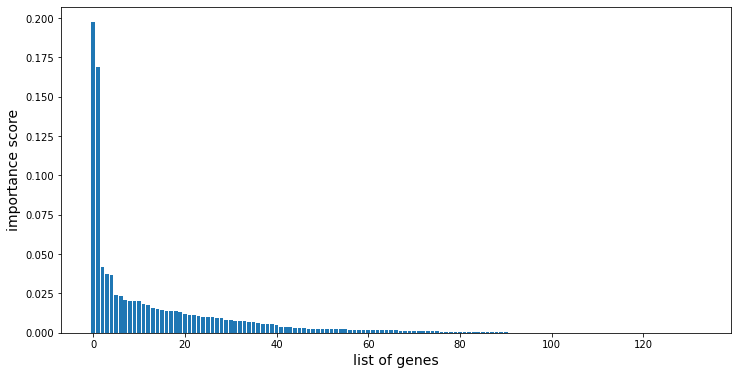

In [89]:
model.fit(X, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.figure(figsize=(12,6))
plt.bar([x for x in range(len(importance))], sorted(importance, reverse = True))
plt.ylabel('importance score', fontsize=14)
plt.xlabel('list of genes', fontsize=14)
plt.show()

[115, 236, 310, 1085, 1328, 1594, 1597, 1902, 3121, 4036, 5637, 6100, 7454, 9188, 12331]
[0.02014277, 0.018374829, 0.04200656, 0.015146018, 0.024216356, 0.020526273, 0.19745463, 0.03737781, 0.16880408, 0.020510497, 0.015868604, 0.017415376, 0.0236202, 0.036454737, 0.0210847]


Text(0.5, 0, 'list of genes')

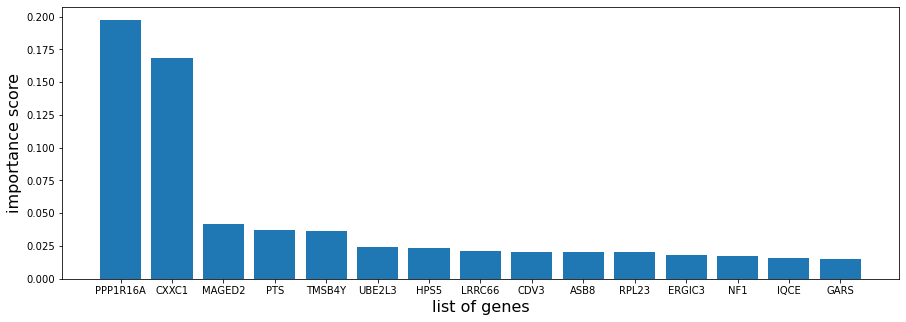

In [91]:
# sorted(importance[:133])
id_symbol_lookup_df = pd.read_csv(id_symbol_lookup_file)
top_genes = []
top_gene_importance = []
importance_threshold = sorted(importance,reverse=True)[15]
for i in range(len(genes_df)):
    if importance[i]>importance_threshold:
        top_genes.append(genes_df['Hugo_ID'][i])
        top_gene_importance.append(importance[i])

print(top_genes)
print(top_gene_importance)
# id_symbol_lookup_df
# print(list(id_symbol_lookup_df['ID']))
# print(list(id_symbol_lookup_df['Hugo_Symbol']))
ids = list(id_symbol_lookup_df['ID'])
symbols = list(id_symbol_lookup_df['Hugo_Symbol'])
top_genes_symbol = []
for i in top_genes:
    top_genes_symbol.append(symbols[i])

top_genes_df = pd.DataFrame({'Hugo_Symbol':top_genes_symbol,'importance':top_gene_importance}) 

top_genes_df = top_genes_df.sort_values(by='importance',axis=0,ascending=[False])

plt.figure(figsize=(15,5))
plt.bar(top_genes_df['Hugo_Symbol'], top_genes_df['importance'])
plt.ylabel('importance score', fontsize=16)
plt.xlabel('list of genes', fontsize=16)

[0 1 1 2 1 0 1 0 2 1 1 2 0 0 2 1 0 0 0 0 0 1 0 0]
[0 1 1 2 1 0 1 0 2 1 1 2 0 0 2 1 0 0 0 0 0 1 0 0]
     0   1   2
0  115   2   0
1    6  68   0
2    7   0  33
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       117
           1       0.97      0.92      0.94        74
           2       1.00      0.82      0.90        40

    accuracy                           0.94       231
   macro avg       0.96      0.91      0.93       231
weighted avg       0.94      0.94      0.93       231



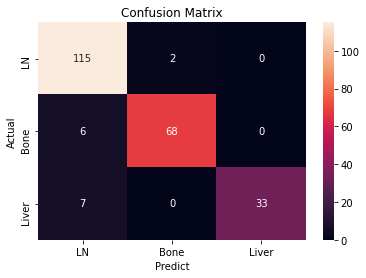

In [64]:


print(y_pred_list)
print(y_val)
class2idx = {
    'LN':0,
    'Bone':1,
    'Liver':2
}

idx2class = {v: k for k, v in class2idx.items()}
# print(idx2class)
mat = [[115,2,0],[6,68,0],[7,0,33]]
print(pd.DataFrame(mat))
confusion_matrix_df = pd.DataFrame(mat).rename(columns=idx2class, index=idx2class)

sns.heatmap(confusion_matrix_df, annot=True, fmt=".3g").set(xlabel="Predict", ylabel = "Actual",title="Confusion Matrix")
print(classification_report(y, y_pred))